In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import warnings
# warnings.simplefilter('error', RuntimeWarning)

from xgboost import XGBClassifier, XGBRegressor

from sklearn import svm, preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error, mean_absolute_error, PredictionErrorDisplay

In [2]:
def symmetric_mean_absolute_percentage_error(actual, predicted):
  
    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted)
    
    delta = 2 *np.abs(predicted - actual)
    denom = (np.abs(predicted) + np.abs(actual))
    return round( 
        np.mean( 
            np.divide(delta, denom, out=np.zeros_like(delta), where=denom!=0) 
        )*100, 2
    ) 
def np_floor(x, decimals=0):
    return np.floor(x * 10**decimals + 0.5) / 10**decimals

In [ ]:
def display_results(clf, inf_type="A"):
    column = f"INF_{inf_type}"

    dplot = data[data["ISO_YEAR"] == 2024][["ISO_YEAR","ISO_WEEK","SPEC_PROCESSED_NB",column]]
    nplot = dplot.drop(column, axis='columns')
    columns = nplot.columns
    # scaler
    if type == "A":
        nplot = pd.DataFrame(scaler_a.transform(nplot), columns=columns)
    else:
        nplot = pd.DataFrame(scaler_b.transform(nplot), columns=columns)

    try:
        pplot = pd.DataFrame(clf.best_estimator_.predict(nplot), columns=[column])
    except:
        pplot = pd.DataFrame(clf.predict(nplot), columns=[column])
    pplot[pplot < 0] = 0.0

    dplot['ISO_SDATE'] = dplot['ISO_YEAR'].astype(str) + '-' + dplot['ISO_WEEK'].astype(str)

    plt.figure(figsize=(14, 4))
    plt.xticks(ticks=range(1, 50), labels=range(1, 50))
    plt.plot(dplot["ISO_WEEK"], dplot[column], label=f'Actual Influenza {inf_type} Count', color='blue')
    plt.plot(dplot["ISO_WEEK"], pplot[column], label=f'Predicted Influenza {inf_type} Count', color='red')
    plt.title(f"Influenza {inf_type}: Actual vs Predicted (Year=2024)")
    plt.xlabel("Weeks")
    plt.ylabel("Influenza Count")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if inf_type == "A":
        models[0].append(pplot[column])
    else:
        models[1].append(pplot[column])
    
    residuals = PredictionErrorDisplay(y_pred=pplot[column], y_true=np.copy(dplot[column]))
    residuals.plot()
    plt.title(f"Influenza {inf_type}: Residuals (Year=2024)")
    plt.show()

In [4]:
data = pd.read_csv("data.csv")
data = data.fillna(0).filter(["ISO_SDATE","ISO_YEAR","ISO_WEEK","SPEC_PROCESSED_NB","INF_A","INF_B"])
data.head()

,ISO_SDATE,ISO_YEAR,ISO_WEEK,SPEC_PROCESSED_NB,INF_A,INF_B
0,2001-12-30T16:00:00.000Z,2002,1,10.0,0.0,0.0
1,2002-01-06T16:00:00.000Z,2002,2,18.0,0.0,0.0
2,2002-01-13T16:00:00.000Z,2002,3,17.0,0.0,0.0
3,2002-01-20T16:00:00.000Z,2002,4,13.0,0.0,0.0
4,2002-01-27T16:00:00.000Z,2002,5,20.0,0.0,0.0


<Axes: xlabel='ISO_SDATE', ylabel='INF_A'>

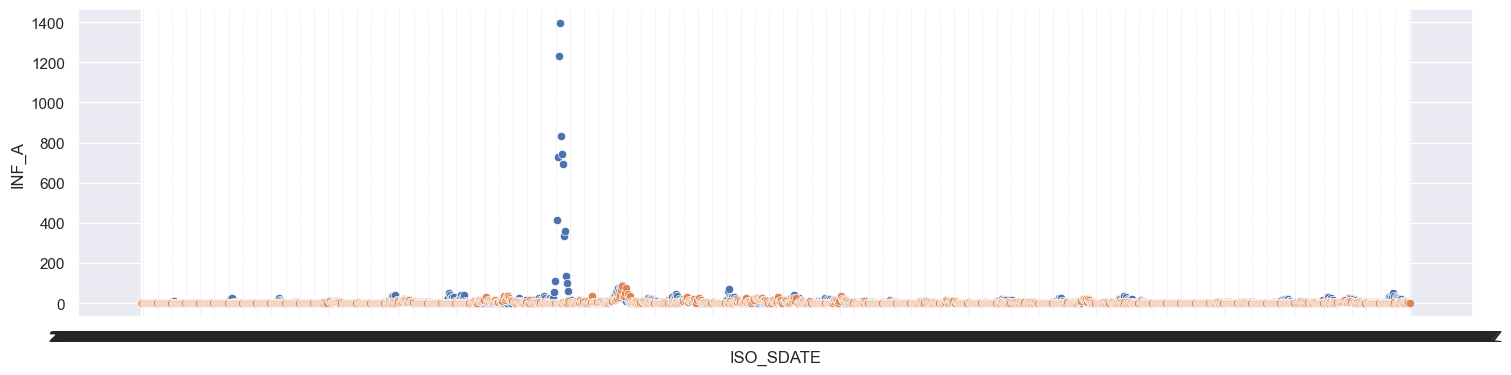

In [5]:
sns.set(rc={"figure.figsize":(18, 4)}) #width=8, height=4
sns.scatterplot(x="ISO_SDATE", y="INF_A", data=data)
sns.scatterplot(x="ISO_SDATE", y="INF_B", data=data)

In [6]:
stuff = data.drop("ISO_SDATE", axis='columns').corr()
stuff.style.background_gradient(cmap='coolwarm')

,ISO_YEAR,ISO_WEEK,SPEC_PROCESSED_NB,INF_A,INF_B
ISO_YEAR,1.000000,-0.011837,-0.111165,-0.045205,-0.051362
ISO_WEEK,-0.011837,1.000000,0.025785,0.017752,0.057901
SPEC_PROCESSED_NB,-0.111165,0.025785,1.000000,0.882485,0.241055
INF_A,-0.045205,0.017752,0.882485,1.000000,0.021382
INF_B,-0.051362,0.057901,0.241055,0.021382,1.000000


In [7]:
# Store name, R2, RMSE, MAE, SMAPE, and best params
results_A = [[],[],[],[],[],[]]
results_B = [[],[],[],[],[],[]]
def get_results(name, actual, pred, best_params, results = results_A):
    results[0].append(name)
    results[1].append(r2_score(actual, pred))
    results[2].append(root_mean_squared_error(actual, pred))
    results[3].append(mean_absolute_error(actual, pred))
    results[4].append(symmetric_mean_absolute_percentage_error(actual, pred))
    results[5].append(best_params)

scoring = make_scorer(symmetric_mean_absolute_percentage_error, greater_is_better=False)

In [8]:
grouped_data = data.drop("ISO_SDATE", axis='columns').groupby(['ISO_YEAR'])
train_set = []
test_set = []

for year, group in grouped_data:
    try:
        train, test = train_test_split(group, test_size=0.2, random_state=782)
        train_set.append(train)
        test_set.append(test)
    except Exception:
        train_set.append(group)

train = pd.concat(train_set)
test = pd.concat(test_set)
Y_train_A = train['INF_A']
Y_test_A = test['INF_A']
X_train_A = train.drop(["INF_A","INF_B"], axis='columns')
X_test_A = test.drop(["INF_A","INF_B"], axis='columns')
Y_train_B = train['INF_B']
Y_test_B = test['INF_B']
X_train_B = train.drop(["INF_A","INF_B"], axis='columns')
X_test_B = test.drop(["INF_A","INF_B"], axis='columns')

In [9]:
scaler_a = StandardScaler()
scaler_b = StandardScaler()
cols = X_train_A.columns
X_train_A = pd.DataFrame(scaler_a.fit_transform(X_train_A), columns=cols)
X_test_A  = pd.DataFrame(scaler_a.transform(X_test_A), columns=cols)
X_train_B = pd.DataFrame(scaler_b.fit_transform(X_train_B), columns=cols)
X_test_B  = pd.DataFrame(scaler_b.transform(X_test_B), columns=cols)

models = [[],[]]

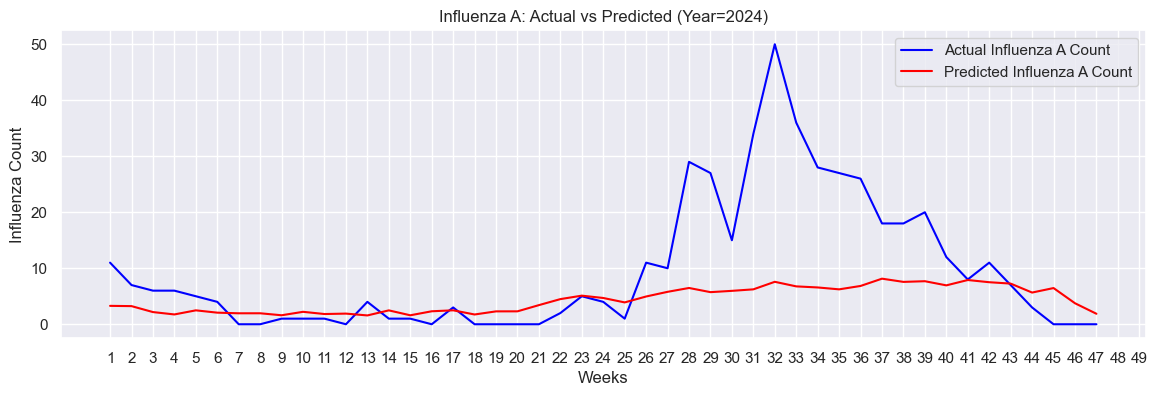

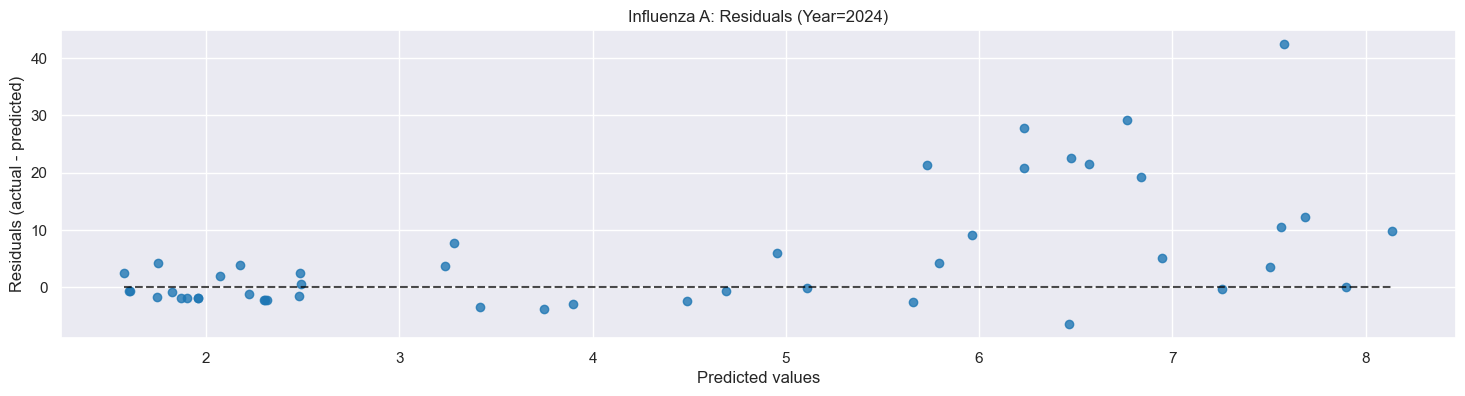

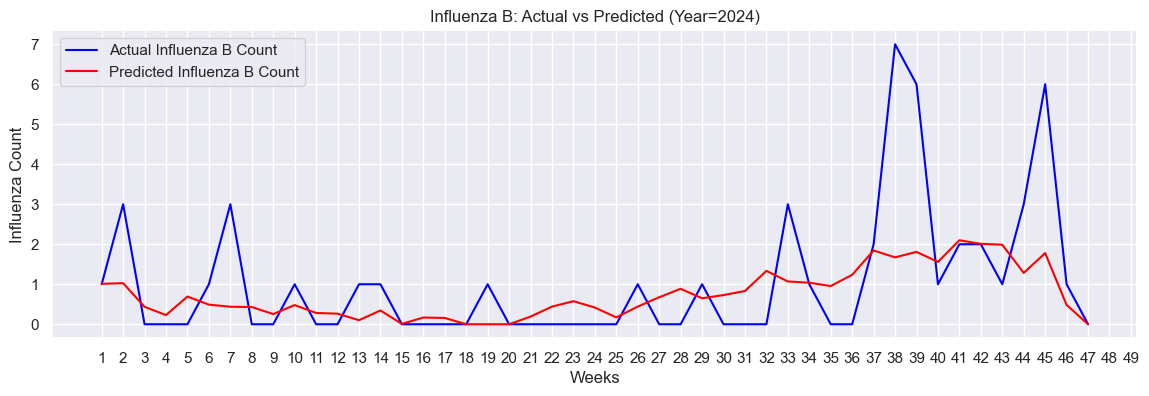

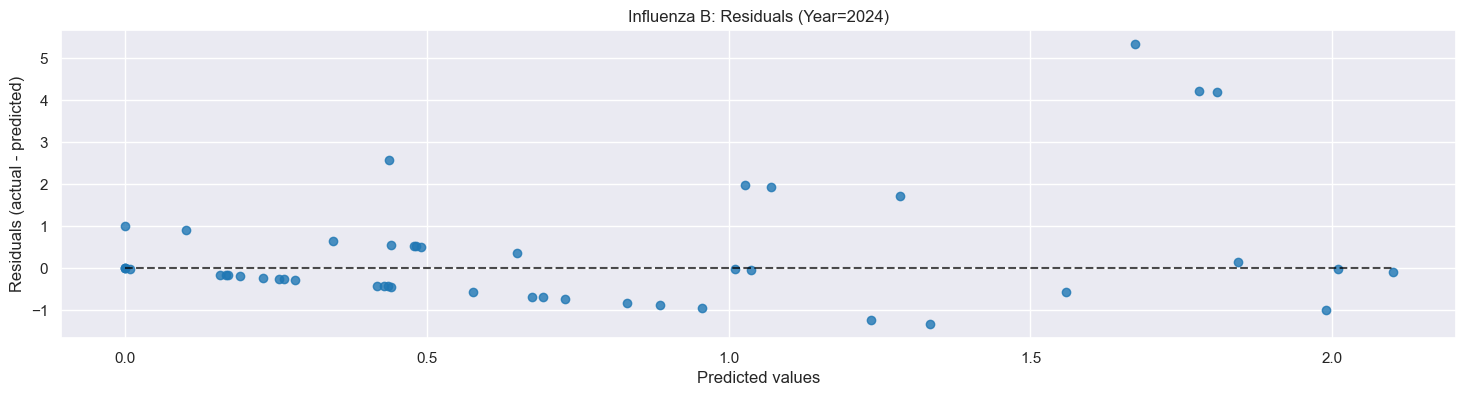

In [10]:
param_grid = [
  {'kernel': ['rbf'], 'gamma': ['scale','auto'], 'C': [0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 0.2, 0.3, 0.4]},
  {'kernel': ['linear'], 'gamma': ['scale','auto'], 'C': [0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 0.2, 0.3, 0.4]}
]
svr_A = GridSearchCV(SVR(), param_grid, cv=3, scoring=scoring,n_jobs=-1)

svr_A.fit(X_train_A, Y_train_A)
pred = svr_A.best_estimator_.predict(X_test_A)
get_results("SVR", Y_test_A, pred, svr_A.best_params_)
display_results(svr_A)

svr_B = svr_A
svr_B.fit(X_train_B, Y_train_B)
pred = svr_B.best_estimator_.predict(X_test_A)
get_results("SVR", Y_test_B, pred, svr_B.best_params_, results_B)
display_results(svr_B, "B")

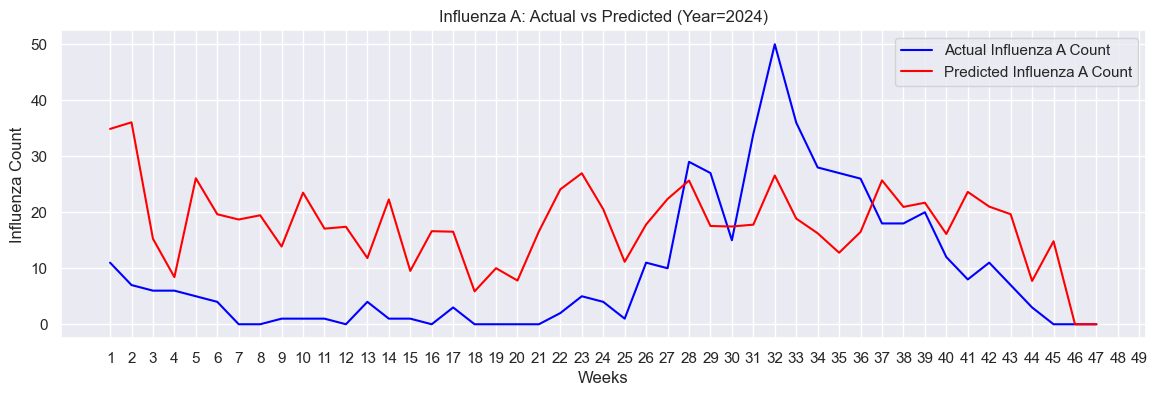

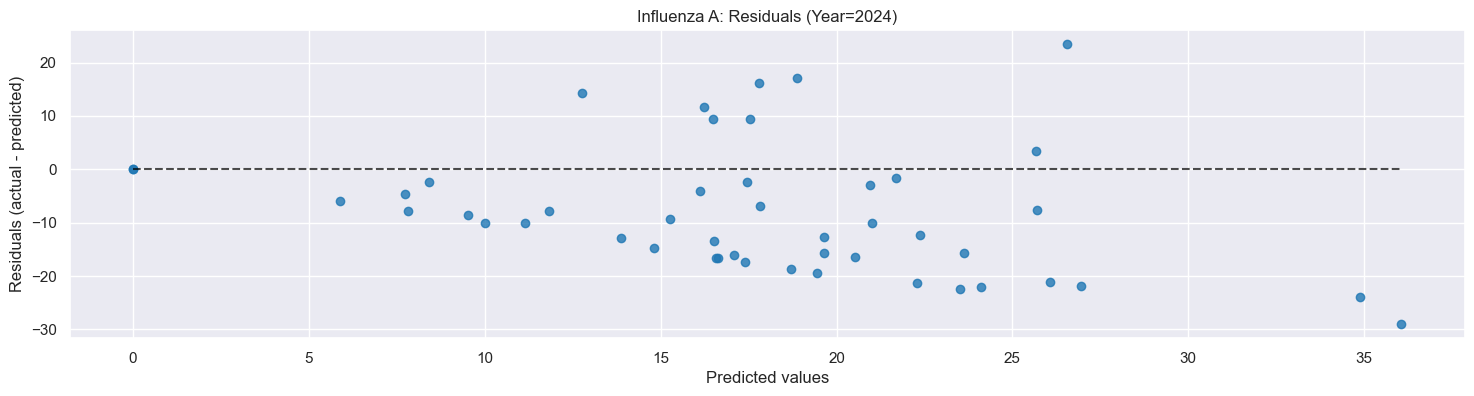

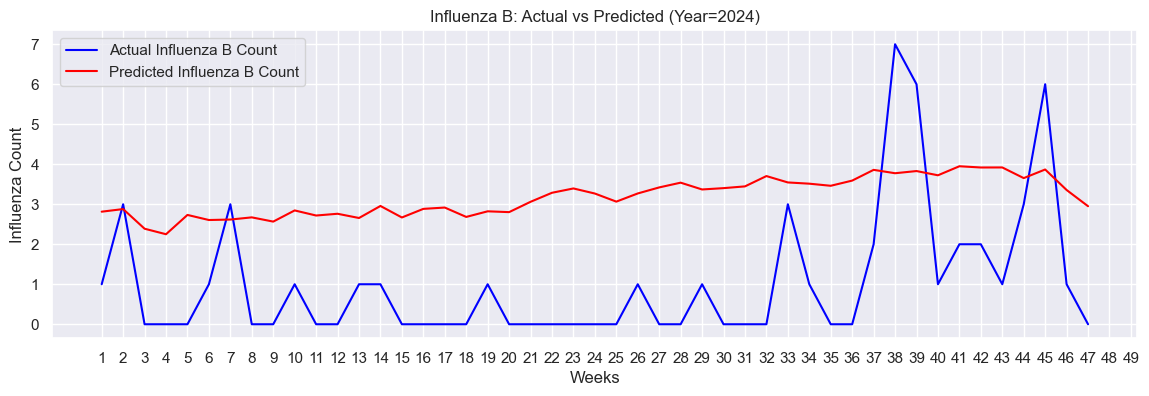

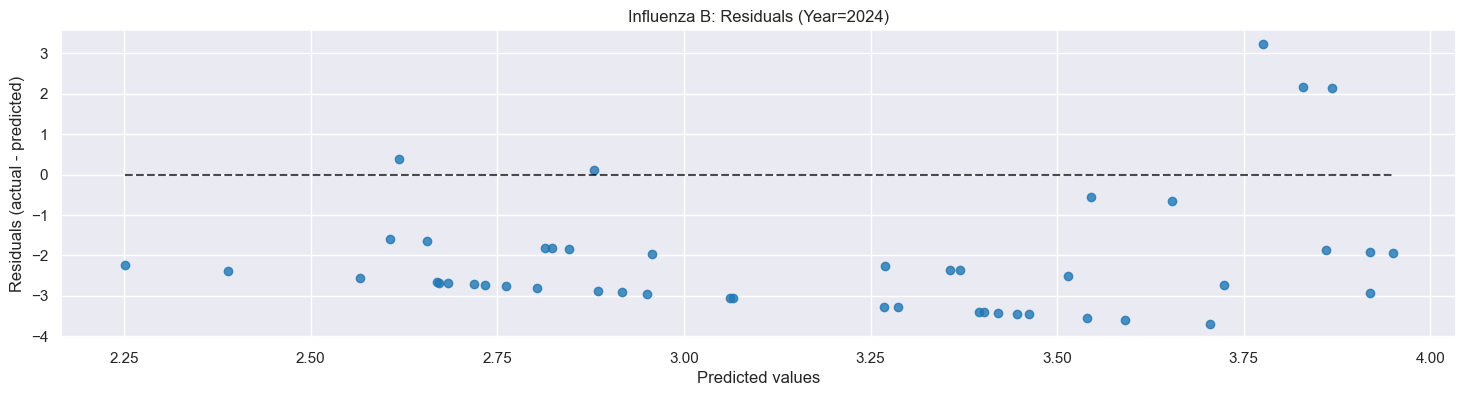

In [11]:
lr_A = LinearRegression(n_jobs=-1)

lr_A.fit(X_train_A, Y_train_A)
pred = lr_A.predict(X_test_A)
get_results("Linear Regression", Y_test_A, pred, None)
display_results(lr_A)


lr_B = lr_A
lr_B.fit(X_train_B, Y_train_B)
pred = lr_B.predict(X_test_B)
get_results("Linear Regression", Y_test_B, pred, None, results_B)
display_results(lr_B, "B")

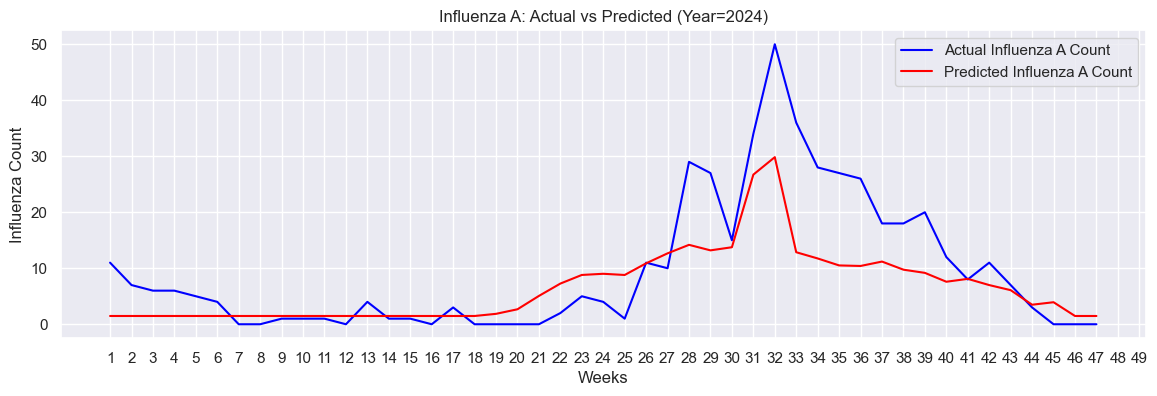

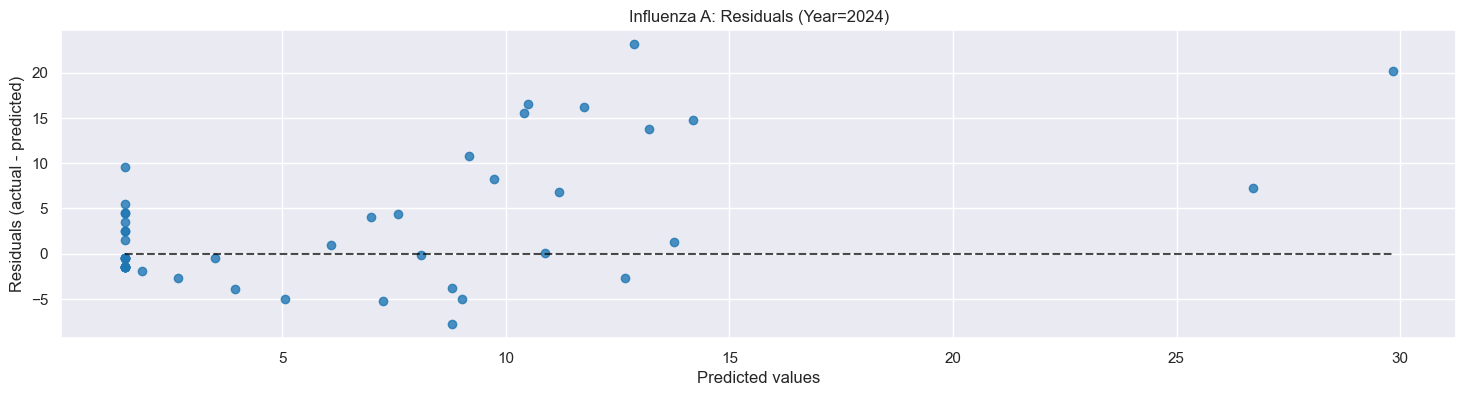

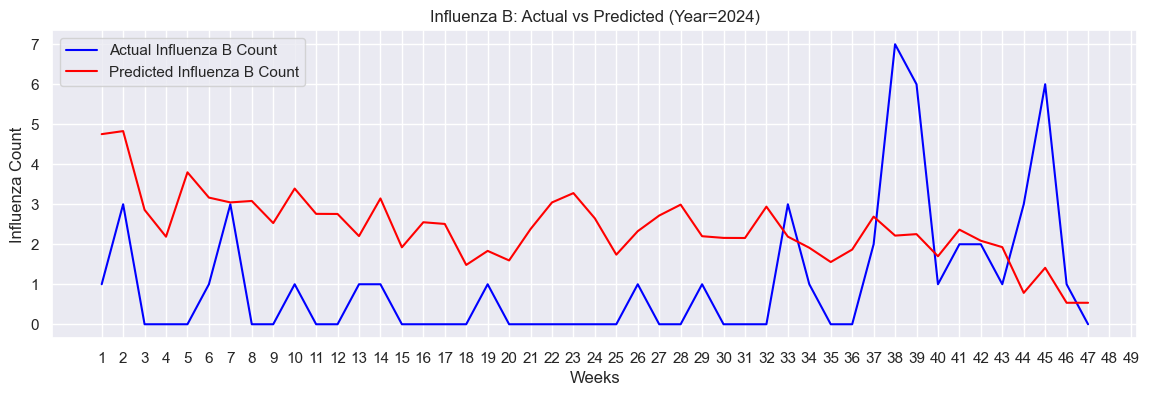

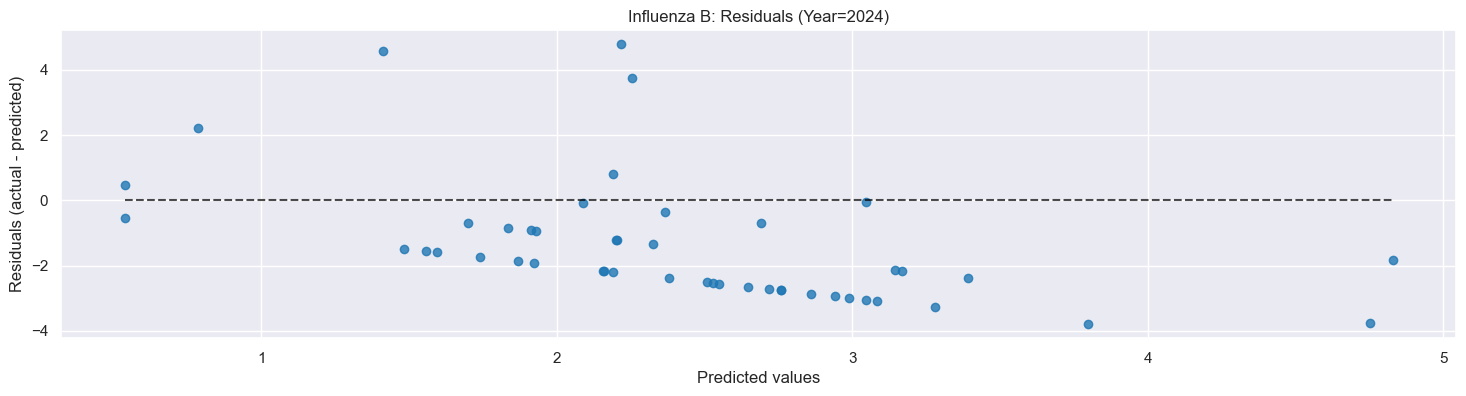

In [12]:
param_grid = [
  {'solver': ['lbfgs'], 'alpha': [0.1, 0.01, 0.001], 'hidden_layer_sizes': [(3,2),(3,3),(3,4)]},
  {'solver': ['adam'], 'alpha': [0.1, 0.01, 0.001], 'hidden_layer_sizes': [(3,2),(3,3),(3,4)]},
]
mlp_A = GridSearchCV(MLPRegressor(random_state=15, max_iter=100000), param_grid, cv=3, scoring=scoring,n_jobs=-1)

mlp_A.fit(X_train_A, Y_train_A)
pred = mlp_A.best_estimator_.predict(X_test_A)
get_results("MLP", Y_test_A, pred, mlp_A.best_params_)
display_results(mlp_A)

mlp_B = mlp_A
mlp_B.fit(X_train_B, Y_train_B)
pred = mlp_B.best_estimator_.predict(X_test_B)
get_results("MLP", Y_test_B, pred, mlp_B.best_params_, results_B)
display_results(mlp_B, "B")

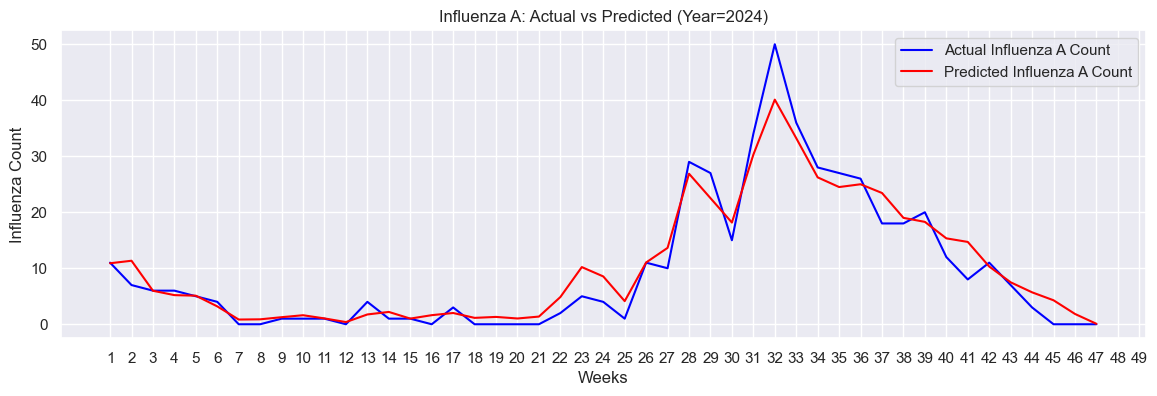

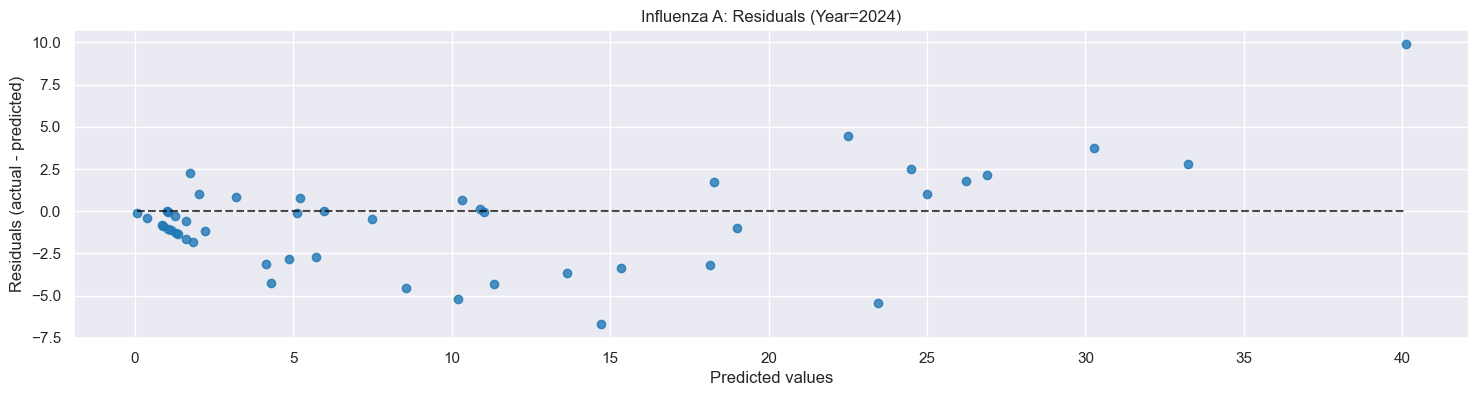

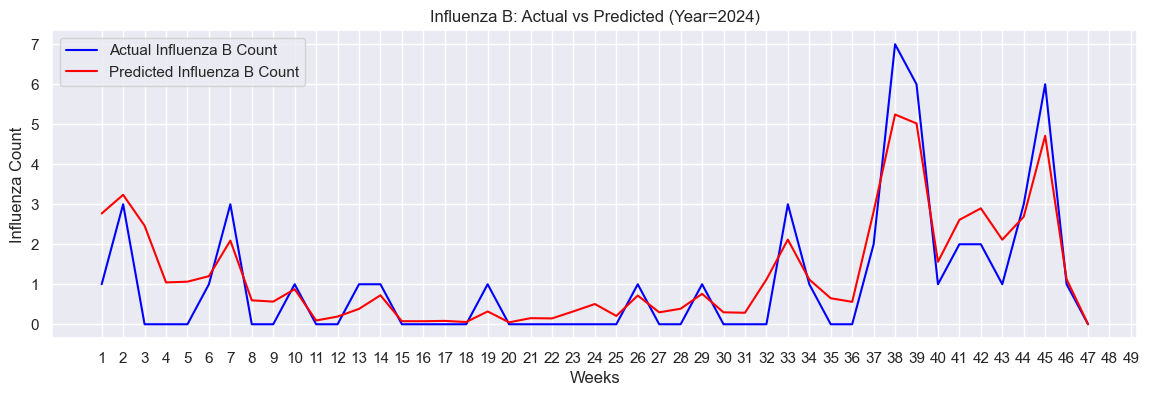

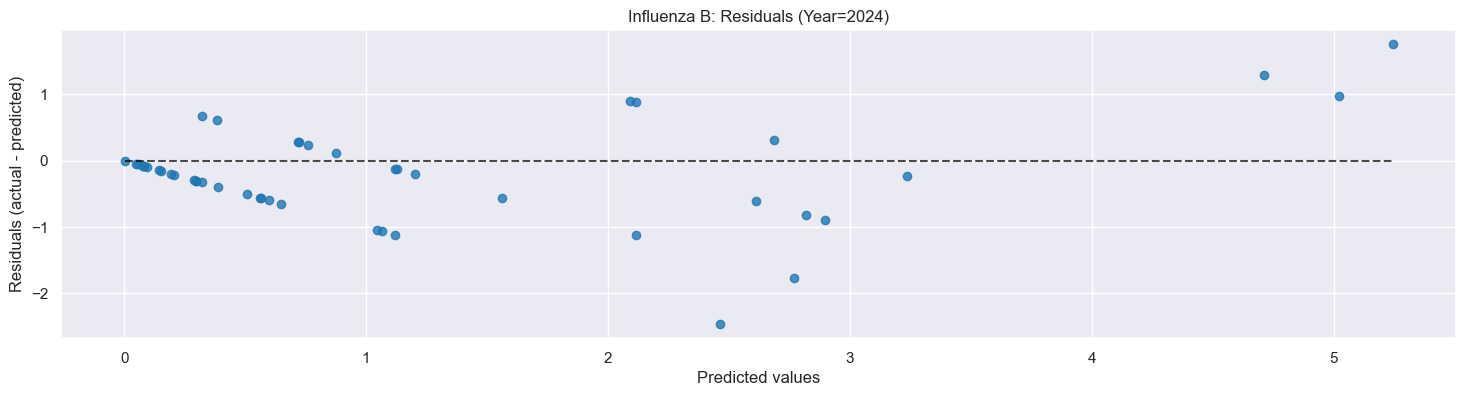

In [13]:
param_grid = [
  {'max_features':[3], 'n_estimators':[100,500,1000], 'criterion':['squared_error','poisson']}
]
rf_A = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring=scoring,n_jobs=-1)

rf_A.fit(X_train_A, Y_train_A)
pred = rf_A.predict(X_test_A)
get_results("Random Forest", Y_test_A, pred, rf_A.best_params_)
display_results(rf_A)

rf_B = rf_A
rf_B.fit(X_train_B, Y_train_B)
pred = rf_B.predict(X_test_B)
get_results("Random Forest", Y_test_B, pred, rf_B.best_params_, results_B)
display_results(rf_B, "B")

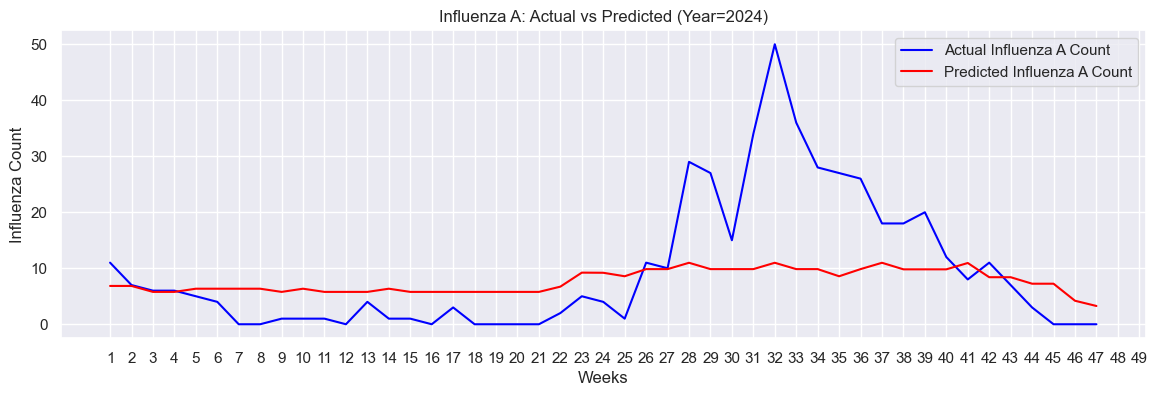

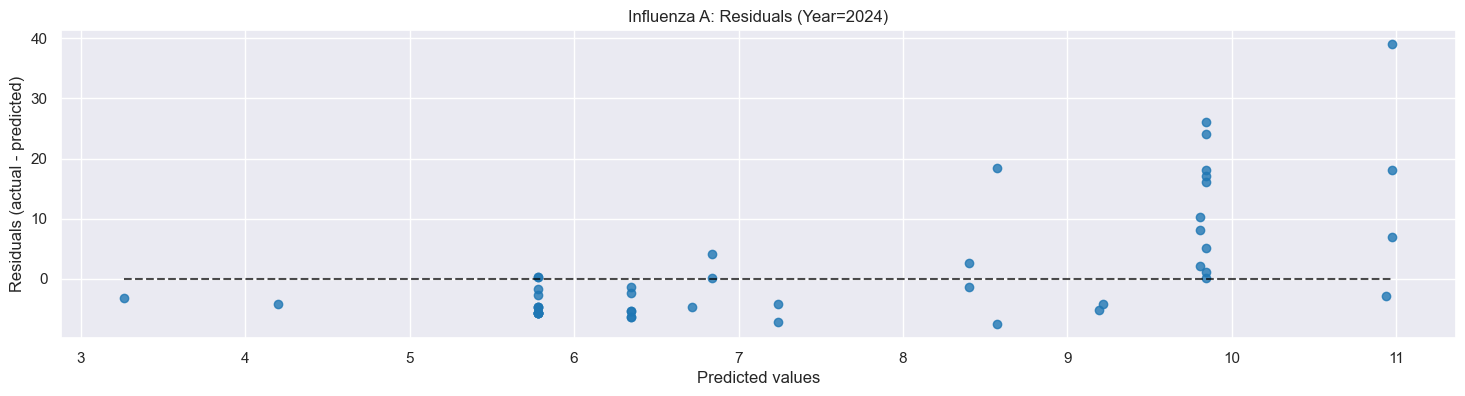

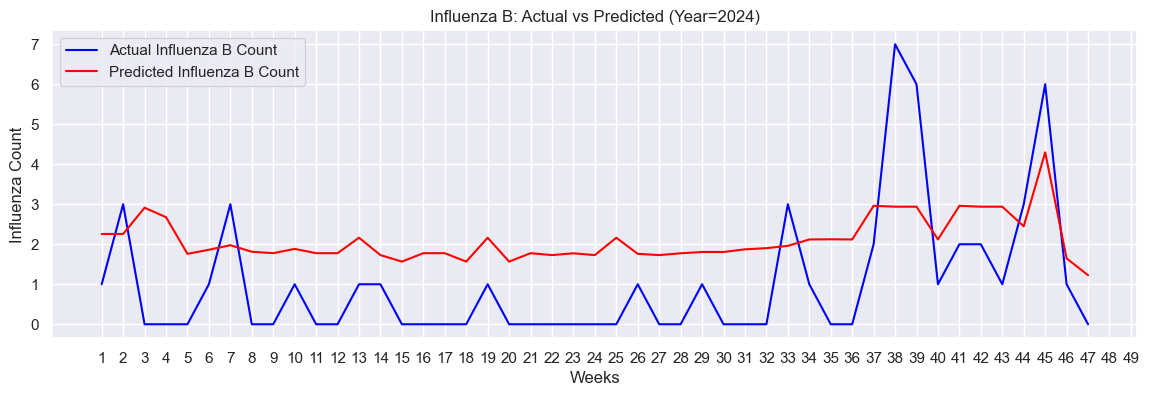

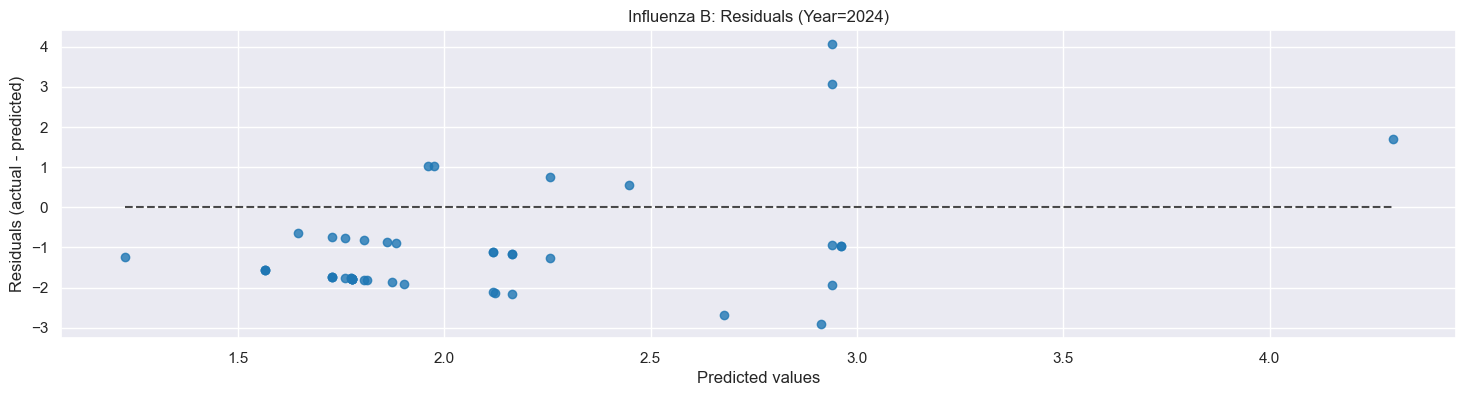

In [14]:
param_grid = [
    {"learning_rate":[0.01, 0.5, 0.1, 0.3], "n_estimators":range(80, 320, 40), "max_depth":range(2, 8, 2)}
]
xgb_A = GridSearchCV(XGBRegressor(), param_grid = param_grid, cv=3, scoring=scoring,n_jobs=-1)
xgb_A.fit(X_train_A, Y_train_A)
pred = xgb_A.predict(X_test_A)
get_results("XGBoost", Y_test_A, pred, xgb_A.best_params_)
display_results(xgb_A)

xgb_B = xgb_A
xgb_B.fit(X_train_B, Y_train_B)
pred = xgb_B.predict(X_test_B)
get_results("XGBoost", Y_test_B, pred, xgb_B.best_params_, results_B)
display_results(xgb_B, "B")

In [15]:
df = pd.DataFrame(np.array(results_A).T, columns=["Model","R2", "RMSE", "MAE", "SMAPE", "Best Params"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.max_colwidth', 1000):  # more options can be specified also
    display(df)

,Model,R2,RMSE,MAE,SMAPE,Best Params
0,SVR,0.011707,46.097079,5.660011,135.5,"{'C': 1, 'epsilon': 0.4, 'gamma': 'auto', 'kernel': 'rbf'}"
1,Linear Regression,0.673723,26.486458,22.003022,171.2,None
2,MLP,0.964372,8.752428,3.896399,129.79,"{'alpha': 0.01, 'hidden_layer_sizes': (3, 3), 'solver': 'adam'}"
3,Random Forest,0.861974,17.227063,3.29992,111.61,"{'criterion': 'squared_error', 'max_features': 3, 'n_estimators': 100}"
4,XGBoost,0.735351,23.854269,5.070907,127.24,"{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 280}"


In [16]:
df = pd.DataFrame(np.array(results_B).T, columns=["Model", "R2", "RMSE", "MAE", "SMAPE", "Best Params"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.max_colwidth', 1000):  # more options can be specified also
    display(df)

,Model,R2,RMSE,MAE,SMAPE,Best Params
0,SVR,0.141398,4.886827,2.341923,151.54,"{'C': 1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}"
1,Linear Regression,0.034014,5.183421,3.512127,143.42,None
2,MLP,0.331254,4.312822,2.572576,140.78,"{'alpha': 0.001, 'hidden_layer_sizes': (3, 4), 'solver': 'adam'}"
3,Random Forest,0.717291,2.804148,1.603229,120.28,"{'criterion': 'squared_error', 'max_features': 3, 'n_estimators': 500}"
4,XGBoost,0.537338,3.587261,2.360779,134.82,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 120}"


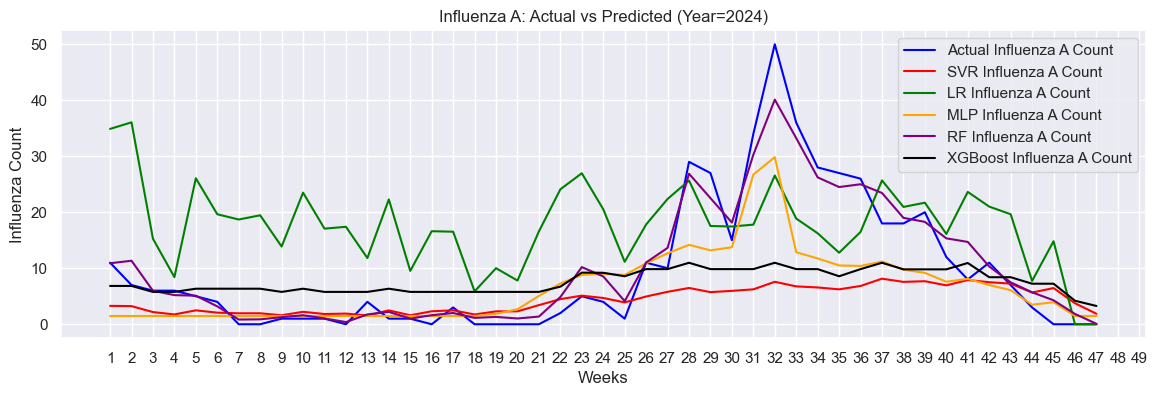

In [17]:
weeks = range(1, 50)
dplot = data[data["ISO_YEAR"] == 2024][["ISO_YEAR","ISO_WEEK","SPEC_PROCESSED_NB","INF_A","INF_B"]]
inf_type = "A"
column = "INF_A"
plt.figure(figsize=(14, 4))
plt.xticks(ticks=range(1, 50), labels=range(1, 50))
plt.plot(dplot["ISO_WEEK"], dplot[column], label=f'Actual Influenza {inf_type} Count', color='blue')
plt.plot(dplot["ISO_WEEK"], models[0][0], label=f'SVR Influenza {inf_type} Count', color='red')
plt.plot(dplot["ISO_WEEK"], models[0][1], label=f'LR Influenza {inf_type} Count', color='green')
plt.plot(dplot["ISO_WEEK"], models[0][2], label=f'MLP Influenza {inf_type} Count', color='orange')
plt.plot(dplot["ISO_WEEK"], models[0][3], label=f'RF Influenza {inf_type} Count', color='purple')
plt.plot(dplot["ISO_WEEK"], models[0][4], label=f'XGBoost Influenza {inf_type} Count', color='black')

plt.title(f"Influenza {inf_type}: Actual vs Predicted (Year=2024)")
plt.xlabel("Weeks")
plt.ylabel("Influenza Count")
plt.legend()
plt.grid(True)
plt.show()

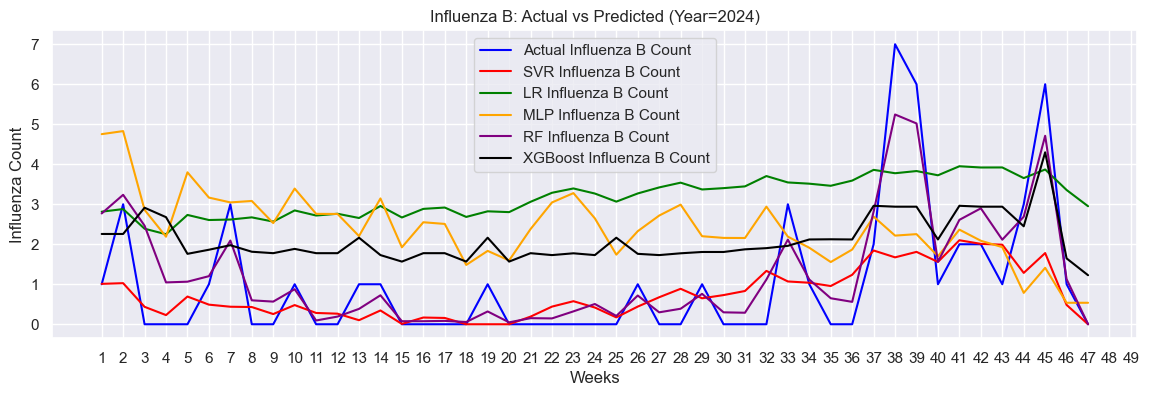

In [18]:
weeks = range(1, 50)
dplot = data[data["ISO_YEAR"] == 2024][["ISO_YEAR","ISO_WEEK","SPEC_PROCESSED_NB","INF_A","INF_B"]]
inf_type = "B"
column = "INF_B"
plt.figure(figsize=(14, 4))
plt.xticks(ticks=range(1, 50), labels=range(1, 50))
plt.plot(dplot["ISO_WEEK"], dplot[column], label=f'Actual Influenza {inf_type} Count', color='blue')
plt.plot(dplot["ISO_WEEK"], models[1][0], label=f'SVR Influenza {inf_type} Count', color='red')
plt.plot(dplot["ISO_WEEK"], models[1][1], label=f'LR Influenza {inf_type} Count', color='green')
plt.plot(dplot["ISO_WEEK"], models[1][2], label=f'MLP Influenza {inf_type} Count', color='orange')
plt.plot(dplot["ISO_WEEK"], models[1][3], label=f'RF Influenza {inf_type} Count', color='purple')
plt.plot(dplot["ISO_WEEK"], models[1][4], label=f'XGBoost Influenza {inf_type} Count', color='black')

plt.title(f"Influenza {inf_type}: Actual vs Predicted (Year=2024)")
plt.xlabel("Weeks")
plt.ylabel("Influenza Count")
plt.legend()
plt.grid(True)
plt.show()